In [1]:
import sys

sys.path.append("../../functions")

from Utils import *
from Plotting import *
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# from sklearn.linear_model import LinearRegression
# import seaborn as sns
import warnings
import seaborn
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats
from scipy.special import logsumexp
from itertools import product
from functools import partial
from multiprocessing import Pool

In [2]:
import random
import numpy as np

seed = 12
random.seed(seed)
np.random.seed(seed)

In [3]:
lv_induction_data[lv_induction_data["cresp"]==1]["Lreward"].std()

NameError: name 'lv_induction_data' is not defined

In [6]:
raw_data = pd.read_csv("../../data/twoArmedandit_with_confidence.csv")
data = raw_data[["sub", "condition", "cresp", "resp", "cj","cor", "phase", "trial", "trial_rev","reward", "Lreward", "Hreward" ]]
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [13]:
## def logll
def get_states_prob_hsmm(dist_params, log_emmission_prob_seq, T, durations):
    
    D = len(durations)
    
    dist = scipy.stats.nbinom(*dist_params)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    log_alpha = np.full((T+1, 2), -np.inf)
    log_alpha[0,:] = 1
    log_alpha[0,:] = log_alpha[0,:] - logsumexp(log_alpha[0,:])

    state_k_prob = np.zeros((T,2, D))

    for t, time in enumerate(range(1,T+1)):
        temp_d = np.zeros((2,D))
        for k, current_time in enumerate(durations):
            if current_time == 1:
                k_emmission_prob = 0
                d_emmission_prob = log_emmission_prob_seq[t,:, k]
            elif time - current_time <0 :
                k_emmission_prob = -np.inf
                d_emmission_prob = -np.inf
            else:
                k_emmission_prob = log_emmission_prob_seq[t-1,:, k-1]
                d_emmission_prob = log_emmission_prob_seq[t,:,k]

            state_k_prob[t,:,k] = k_emmission_prob + np.flip(log_alpha[time-current_time,:])
            temp_d[:,k] = d_emmission_prob + transition_log[k] + np.flip(log_alpha[time-current_time,:])
        log_alpha[time,:] = logsumexp(temp_d, axis=-1)

    state_log_probs = logsumexp(state_k_prob, axis = -1)
    sum_probs = logsumexp(state_log_probs, axis=1, keepdims=True)
    state_log_probs = state_log_probs - sum_probs
    state_probs = np.exp(state_log_probs)
    return state_probs

def sub_state_prob_hsmm(sub_id, data, emission_var = 8):
  
    sub_data = data[data["sub"] == subjects[sub_id]]
    T = len(sub_data)
    rewards = sub_data["reward"].to_numpy()*100
    actions = sub_data["resp"].to_numpy()

    log_emmision_prob = np.zeros((T, 2)) # T = 1 to 400
    high_reward_dist = scipy.stats.norm(60, emission_var)
    low_reward_dist = scipy.stats.norm(40, emission_var)

    log_emmision_prob[:,0] = low_reward_dist.logpdf(rewards) # low_reward
    log_emmision_prob[:,1] = high_reward_dist.logpdf(rewards) # high_reward


    durations = range(1,71)
    D = len(durations)


    log_emmission_prob_seq = np.zeros((T,2,D)) # time from t=1 to T(400), states,durations = (1,40),

    for t, time in enumerate(range(1,T+1)):
            for d, duration in enumerate(durations):
                if t-d < 0:
                    log_emmission_prob_seq[t,:,d] = -np.inf
                else:
                    log_emmission_prob_seq[t,0,d] = np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 0]) + \
                                                    np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 1])

                    log_emmission_prob_seq[t,1,d] = np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 0]) + \
                                        np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 1])
    
    p_range = np.linspace(0.01, 0.99, 16)  
    n_range = np.arange(1, 100, 6)
    grid = list(product(n_range, p_range))
    
    func = partial(get_states_prob_hsmm, log_emmission_prob_seq= log_emmission_prob_seq, T = T, durations = durations)

    with Pool(128) as pool:
        results = pool.map(func, grid)

    return grid,results

def protected_log(x):
    return np.log((1e-200 / 2) + (1 - 1e-200) * x)

def calculate_mf_probs(params, resps, rewards):
    alpha, beta = params[:2]
    Q = np.array([0.5, 0.5])
    probabilities = np.zeros(len(resps))
    for t, (resp, reward) in enumerate(zip(resps, rewards)):
        choice_prob = softmax_func(Q, beta)
        probabilities[t] = choice_prob[resp]
        Q[resp] += alpha * (reward - Q[resp])
    return probabilities



def ll_mix_model(params, resps, rewards, mb_probs):
    gamma, alpha, beta = params
    
    mf_probs = calculate_mf_probs((alpha,beta), resps, rewards)
    mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
    
    return -np.sum(protected_log(mix_probs))

def fit_n_times(n_fitting, params_ranges, func, func_args):
    results = [minimize(func, x0=[np.random.uniform(*r) for r in params_ranges], args=func_args, bounds=params_ranges) for _ in range(n_fitting)]
    best_result = min(results, key=lambda x: x.fun if x.success else np.inf)
    return best_result.x, best_result.fun



def calculate_mf_probs(params, resps, rewards):
    alpha, beta = params[:2]
    Q = np.array([0.5, 0.5])
    probabilities = np.zeros(len(resps))
    for t, (resp, reward) in enumerate(zip(resps, rewards)):
        choice_prob = softmax_func(Q, beta)
        probabilities[t] = choice_prob[resp]
        Q[resp] += alpha * (reward - Q[resp])
    return probabilities


def model_subj_conf_dist(params, confs, resp_probs):
    lbound, scale = params[0], params[1]
    hbound = scale * (5 - lbound) + lbound
    model_confs = linear_transform_on_array(resp_probs, [0, 1], [lbound, hbound])
    return mean_square_distance(confs, model_confs)


def process_fit(args):
    i, results, actions, rewards, confs,T = args
    states_prob_hsmm = results[i]
    mb_probs = states_prob_hsmm[np.arange(T), actions]
    x, ll = fit_n_times(20, params_ranges=[[0,1],[0.01, 1], [0.01, 100]],
                         func=ll_mix_model, func_args=(actions, rewards, mb_probs))
    gamma = x[0]
    mf_probs = calculate_mf_probs(x[1:], actions, rewards)
    mix_probs = gamma*mf_probs + (1-gamma)*mb_probs 
    
    conf_params, conf_dist = fit_n_times(5, params_ranges=[[1,5],[0.01, 1]],
                         func=model_subj_conf_dist, func_args=(confs,mix_probs))

    
    return ll, x, conf_params, mb_probs




def conf_dist(params, resps, rewards, confs, mb_probs):
    gamma, alpha, beta, lbound, bound_range = params
    hbound = bound_range * (5 - lbound) + lbound

    mf_probs = calculate_mf_probs((alpha,beta), resps, rewards)
    mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
    model_confs = linear_transform_on_array(mix_probs, [0, 1], [lbound, hbound])
    dist = mean_square_distance(confs, model_confs)
    
    return dist


def get_ll_model(sub_id, data): 
    sub_data = data[data["sub"] == subjects[sub_id]]
    rewards = sub_data["reward"].to_numpy()
    actions = sub_data["resp"].to_numpy()
    confs = sub_data["cj"].to_numpy()
    T = len(actions)
    grid, results = sub_state_prob_hsmm(sub_id, data)
    
    args_list = [(i, results, actions, rewards, confs, T) for i in range(len(results))]
    
    with Pool(60) as pool:
        results_parallel = pool.map(process_fit, args_list)
    
    neg_ll_seq, params, conf_params, mb_probs = zip(*results_parallel)
    
    min_idx = np.argmin(neg_ll_seq)
    neg_ll = neg_ll_seq[min_idx]
    mf_x = params[min_idx]
    mb_x = grid[min_idx]
    conf_x = conf_params[min_idx]
    mb_prob = mb_probs[min_idx]
    
    dist = conf_dist((*mf_x, *conf_x), actions, rewards, confs, mb_prob)
    
    return neg_ll, mf_x, mb_x, conf_x, dist


def process_fit_backward(args):
    i, results, actions, rewards, confs, T = args
    states_prob_hsmm = results[i]
    mb_probs = states_prob_hsmm[np.arange(T), actions]
    x, min_dist = fit_n_times(60, params_ranges=[[0,1],[0.01, 1], [0.01, 100], [1, 5], [0.01, 1]],
                         func=conf_dist, func_args=(actions, rewards, confs, mb_probs))
    return min_dist, x, mb_probs

def get_dist_model(sub_id,data): 
    sub_data = data[data["sub"] == subjects[sub_id]]
    rewards = sub_data["reward"].to_numpy()
    actions = sub_data["resp"].to_numpy()
    confs = sub_data["cj"].to_numpy()
    
    T = len(actions)
    grid, results = sub_state_prob_hsmm(sub_id, data)
    
    args_list = [(i, results, actions, rewards, confs, T) for i in range(len(results))]
    
    with Pool(60) as pool:
        results_parallel = pool.map(process_fit_backward, args_list)
    
    dist_seq, params, mb_probs = zip(*results_parallel)
    
    min_idx = np.argmin(dist_seq)
    min_dist = dist_seq[min_idx]
    mf_x = params[min_idx]
    mb_x = grid[min_idx]
    mb_prob = mb_probs[min_idx]
    
    neg_ll = ll_mix_model(mf_x[:3], actions, rewards, mb_prob)
    return min_dist, mf_x, mb_x, neg_ll



In [ ]:
results = []
for sub_id, subject in enumerate(subjects):
    print(sub_id)
    min_dist, mf_x, mb_x, neg_ll = get_dist_model(sub_id, lv_induction_data)
    gamma, alpha, beta, lbound, bound_range = mf_x
    n, p = mb_x
    
    results.append({
        "subject": subject,
        "Confidence Distance": min_dist,
        "neg_ll": neg_ll, 
        "gamma": gamma,
        "alpha": alpha,
        "beta": beta,
        "n": n,
        "p": p,
        "lbound": lbound,
        "bound_range": bound_range,
        "hbound": (5 - lbound) * bound_range + lbound
    })

df = pd.DataFrame(results)

0
1
2
3
4
5
6
7
8
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [18]:
results = []
for sub_id, subject in enumerate(subjects):
    print(sub_id)
    neg_ll, mf_x, mb_x, conf_x, min_dist = get_ll_model(sub_id, lv_induction_data)
    gamma, alpha, beta = mf_x
    n, p = mb_x
    lbound, bound_range = conf_x
    
    results.append({
        "subject": subject,
        "Confidence Distance": min_dist,
        "neg_ll": neg_ll, 
        "gamma": gamma,
        "alpha": alpha,
        "beta": beta,
        "n": n,
        "p": p,
        "lbound": lbound,
        "bound_range": bound_range,
        "hbound": (5 - lbound) * bound_range + lbound
    })

df = pd.DataFrame(results)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [20]:
df.to_csv("../../results/forward_mix_df.csv", index=False)

In [12]:
# df.to_csv("../../results/backward_mix_df.csv", index=False)

In [21]:
pd.read_csv("../../results/backward_mix_df.csv")["Confidence Distance"] < df["Confidence Distance"]

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
45    True
46    True
47    True
48    True
49    True
50    True
51    True
52    True
53    True
Name: Confidence Distance, dtype: bool

In [15]:
pd.read_csv("../../results/forward_mix_df.csv")

,Unnamed: 0,subject,neg_ll,gamma,alpha,beta,n,p,lbound,bound_range,hbound
0,0,45628,50.593572,0.000000,1.000000,38.059897,91,0.794000,3.857266,0.768056,4.734949
1,1,45640,33.245298,0.027690,0.712350,100.000000,97,0.794000,3.603526,0.669527,4.538503
2,2,45664,162.223521,0.801721,1.000000,9.797218,79,0.859333,3.134664,0.010000,3.153318
3,3,45682,138.575742,0.509617,1.000000,8.809201,97,0.859333,1.481264,0.807560,4.322855
4,4,45745,92.620106,0.019974,0.010000,0.010000,85,0.794000,3.300334,0.918179,4.860931
5,5,45760,66.332899,0.061918,0.264796,100.000000,7,0.271333,1.000000,0.913049,4.652196
6,6,45763,54.677945,0.729007,1.000000,26.056441,7,0.336667,1.869126,0.919461,4.747842
7,7,45805,78.915280,0.000000,0.010000,90.662736,85,0.794000,3.995051,0.958454,4.958248
8,8,45829,95.635407,0.216594,1.000000,9.123416,79,0.794000,1.000000,0.842408,4.369631
9,9,45964,120.787574,0.752426,0.840650,13.004615,97,0.859333,1.688098,0.803519,4.349275


<BarContainer object of 70 artists>

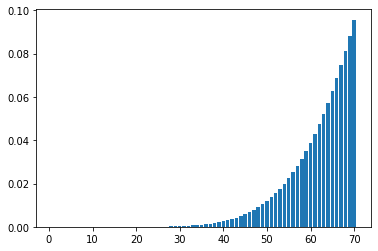

In [164]:
a = scipy.stats.nbinom(13, 0.075333).pmf(range(1,71))/np.sum(scipy.stats.nbinom(13, 0.075333).pmf(range(1,71)))
plt.bar(range(1,71),a)

In [170]:
sub = 46057
sub_data = lv_induction_data[lv_induction_data["sub"] == sub]
rewards = sub_data.reward.to_numpy()
resps = sub_data.resp.to_numpy()
confs = sub_data.cj.to_numpy()

params = fwd_df[fwd_df["subject"] == 46057].iloc[0][["alpha","beta", "gamma", "n", "p", "lbound", "hbound"]]
conf_dist(params, resps, rewards, confs, mb_probs)

NameError: name 'mb_probs' is not defined

In [167]:
lv_induction_data[lv_induction_data["sub"]== 46057]

,sub,condition,cresp,resp,cj,cor,phase,trial,trial_rev,reward,Lreward,Hreward
19188,46057,hc,0,1,1.319192,0,induction,0,19,0.526031,52.603123,59.122801
19189,46057,hc,0,0,1.319192,1,induction,1,18,0.579593,49.815958,57.959285
19190,46057,hc,0,0,1.647811,1,induction,2,17,0.463930,39.574438,46.393013
19191,46057,hc,0,0,1.286869,1,induction,3,16,0.597989,46.852915,59.798902
19192,46057,hc,0,1,1.286869,0,induction,4,15,0.595649,59.564905,62.587240
...,...,...,...,...,...,...,...,...,...,...,...,...
19583,46057,hc,1,1,3.102357,1,induction,17,4,0.550856,22.802401,55.085600
19584,46057,hc,1,1,3.646465,1,induction,18,3,0.500389,41.569615,50.038923
19585,46057,hc,1,1,3.867340,1,induction,19,2,0.499049,51.163866,49.904863
19586,46057,hc,1,1,1.814815,1,induction,20,1,0.525058,52.242708,52.505818


In [168]:
params_df[params_df["subject"] == 46057]

,Unnamed: 0,subject,neg_ll,gamma,alpha,beta,n,p,lbound,bound_range,hbound,model,x_idx,Confidence Distance,transition_mean
11,11.0,46057,75.264673,0.515462,0.575421,29.691447,19,0.532667,1.0,0.72994,3.919759,Forward,12,NaN,16.669587
65,NaN,46057,NaN,0.692402,1.000000,9.080213,17,0.140667,1.0,0.79857,4.194278,Backward,212,1.139362,103.853081


In [158]:
params_df[params_df["transition_mean"] > 100]

,Unnamed: 0,subject,neg_ll,gamma,alpha,beta,n,p,lbound,bound_range,hbound,model,x_idx,Confidence Distance,transition_mean
65,NaN,46057,NaN,0.692402,1.000000,9.080213,17,0.140667,1.000000,0.798570,4.194278,Backward,212,1.139362,103.853081
68,NaN,46114,NaN,0.729589,1.000000,5.362021,33,0.140667,2.876543,0.829386,4.637709,Backward,215,0.306759,201.597156
69,NaN,46159,NaN,0.839149,0.872587,8.130290,17,0.010000,1.000000,0.950187,4.800746,Backward,216,0.418679,1683.000000
74,NaN,46357,NaN,0.793199,0.010000,16.967642,81,0.010000,4.130739,1.000000,5.000000,Backward,221,0.551479,8019.000000
82,NaN,46555,NaN,0.669742,1.000000,3.828404,33,0.075333,1.000000,0.660673,3.642692,Backward,229,0.485835,405.053097
84,NaN,46591,NaN,0.820096,0.873203,9.686844,17,0.140667,1.204089,0.976567,4.911052,Backward,231,0.432191,103.853081
90,NaN,46750,NaN,0.841490,1.000000,0.747036,65,0.336667,1.000000,0.679912,3.719648,Backward,237,1.410600,128.069307
91,NaN,46756,NaN,0.719110,0.064778,10.139683,49,0.271333,1.000000,0.688785,3.755141,Backward,238,0.737586,131.589681
100,NaN,47269,NaN,0.914840,0.510568,12.726572,65,0.206000,1.475799,0.826205,4.387512,Backward,247,0.952781,250.533981
102,NaN,47317,NaN,0.400145,0.513167,100.000000,97,0.010000,3.382445,0.313245,3.889136,Backward,249,0.143311,9603.000000


In [ ]:
pd.read_csv

In [49]:
pd.read_csv("../../results/forward_mix_df_2.csv")

,subject,neg_ll,gamma,alpha,beta,n,p
0,45628,50.705112,0.000000,1.000000,72.048720,93.334,0.794000
1,45640,33.293042,0.028682,0.709754,100.000000,93.334,0.794000
2,45664,162.226222,0.801474,1.000000,9.794989,80.002,0.859333
3,45682,138.495805,0.506184,1.000000,8.677566,100.000,0.859333
4,45745,92.815706,0.021031,0.010000,0.010000,86.668,0.794000
5,45760,66.960704,0.063912,0.289640,100.000000,13.342,0.467333
6,45763,54.670558,0.730966,1.000000,25.878685,6.676,0.336667
7,45805,78.865749,0.000000,1.000000,72.039025,86.668,0.794000
8,45829,95.710118,0.220831,1.000000,9.124666,80.002,0.794000
9,45964,120.770280,0.753955,0.840428,12.974794,100.000,0.859333


In [70]:
results = []
for sub_id, subject in enumerate(subjects):
    print(sub_id)
    neg_ll, mf_x, mb_x, conf_x = get_ll_model(sub_id, lv_induction_data)
    gamma, alpha, beta = mf_x
    n, p = mb_x
    lbound, bound_range = conf_x
    
    results.append({
        "subject": subject,
        "neg_ll": neg_ll,
        "gamma": gamma,
        "alpha": alpha,
        "beta": beta,
        "n": n,
        "p": p,
        "lbound": lbound,
        "bound_range": bound_range,
        "hbound": (5 - lbound) * bound_range + lbound

    })

df = pd.DataFrame(results)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [81]:
mix_df = pd.read_csv("../../results/forward_mix_df.csv", index_col=0)

In [24]:
def simulate_mix_model(sub_data, params):
    
    alph,beta, gamma, n,p, lbound, hbound = params
    
    lrewards =  sub_data["Lreward"].to_numpy()
    hrewards = sub_data["Hreward"].to_numpy()
    cresps = sub_data["cresp"].to_numpy()
    
    
    T = len(cresps)
    
    # mf
    Q = np.array([0.5, 0.5])
    Q_list = np.zeros((T, 2))
    rewards = np.zeros(T)
    actions = np.zeros(T)
    
    #mb
    durations = range(1,71)
    D = len(durations)
    
    dist = scipy.stats.nbinom(n,p)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    log_alpha = np.full((T+1, 2), -np.inf)
    log_alpha[0,:] = 1
    log_alpha[0,:] = log_alpha[0,:] - logsumexp(log_alpha[0,:])
    log_emmision_prob = np.zeros((T, 2)) # T = 1 to 400
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)
    state_k_prob = np.zeros((T,2, D))
    log_emmission_prob_seq = np.zeros((T,2,D)) # time from t=1 to T(400), states,durations = (1,40),

    

    acc = np.zeros(T)
    chosen_probs = np.zeros(T)
    
    for t,time in enumerate(range(1,T+1)):
        #mf
        low_reward = lrewards[t]
        high_reward = hrewards[t]
        
        mf_probs = softmax_func(Q, beta) #mf prob
        
        #mb
        for k, current_time in enumerate(durations):
            if current_time == 1:
                k_emmission_prob = 0
            elif time - current_time <0 :
                k_emmission_prob = -np.inf
            else:
                k_emmission_prob = log_emmission_prob_seq[t-1,:, k-1]
            state_k_prob[t,:,k] = k_emmission_prob + np.flip(log_alpha[time-current_time,:])
            
        current_log_state = logsumexp(state_k_prob[t], axis = -1)
        current_log_state -= logsumexp(current_log_state, axis=-1)
        mb_probs = np.exp(current_log_state)
        
        # action 
        mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
        resp = np.random.choice([0, 1], p=mix_probs)   
        chosen_probs[t] = mix_probs[resp]
        
        
        if resp == cresps[t]:
            reward = hrewards[t]
            acc[t] = 1
        else:
            acc[t] = 0
            reward = lrewards[t]
        actions[t]= resp
        rewards[t]= reward
        
        #mf update
        prediction_error = reward/100 - Q[resp]
        Q[resp] = Q[resp] + alpha * prediction_error
        
        #mb update
        log_emmision_prob[t,0] = low_reward_dist.logpdf(reward)
        log_emmision_prob[t,1] = high_reward_dist.logpdf(reward)

        temp_d = np.zeros((2,D))
        for d, duration in enumerate(durations):
            if time - duration <0 :
                log_emmission_prob_seq[t,:,d] = -np.inf
                d_emmission_prob = -np.inf
            else:
                log_emmission_prob_seq[t,0,d] = np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 0]) + \
                                                np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 1])
                log_emmission_prob_seq[t,1,d] = np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 0]) + \
                                    np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 1])

                d_emmission_prob = log_emmission_prob_seq[t,:,d]
            temp_d[:,d] = d_emmission_prob + transition_log[d] + np.flip(log_alpha[time-duration,:])
        log_alpha[time,:] = logsumexp(temp_d, axis=-1)

    confs = linear_transform_on_array(chosen_probs, [0, 1], [lbound, hbound])
    return np.mean(acc), np.mean(confs)

    

def run_simulation(sub_id, df):
    """Function to run 120 simulations and compute the average ACC."""
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    params = df[df["subject"] == subjects[sub_id]].iloc[0][["alpha","beta", "gamma", "n", "p", "lbound", "hbound"]]

    
    results = [simulate_mix_model(sub_data, params) for _ in range(100)]
    
    avg_acc = np.mean([res[0] for res in results])
    avg_conf = np.mean([res[1] for res in results])
    
    return subjects[sub_id], avg_acc, avg_conf


In [89]:
results_df.to_csv("../../results/forward_mix_simulation_df.csv", index=False)

In [25]:
import functools
back_df = pd.read_csv("../../results/backward_mix_df.csv")
forward_df = pd.read_csv("../../results/forward_mix_df.csv")

with Pool(processes=60) as pool:
    results = pool.map(functools.partial(run_simulation, df=back_df), range(num_subjects))

# Convert results into a DataFrame for better visualization
back_sim_df = pd.DataFrame(results, columns=["Subject", "performance", "avg_conf"])

In [26]:
back_sim_df.to_csv("../../results/backward_mix_simulation_df.csv")

In [28]:
def calculate_averages(df):
    """
    Group by 'subject' and calculate the mean of 'reward', 'cor', and 'cj'. 
    """
    return df.groupby("subject").agg({"reward": "mean", "cor": "mean", "cj": "mean"}).reset_index()

forward_sim_df = pd.read_csv("../../results/mix_simulation_df.csv")

human_lv_df = lv_induction_data.rename(columns={"sub": "subject"})
human_lv_df = calculate_averages(human_lv_df)
human_lv_df = human_lv_df.rename(columns={"cor": "performance", "cj": "avg_conf"})
forward_sim_df = forward_sim_df.rename(columns={"Subject": "subject"})
back_sim_df = back_sim_df.rename(columns= {"Subject": "subject"})


groups = ["Forward", "Empirical", "Backward"]

avg_df = merge_result_df([forward_sim_df, human_lv_df, back_sim_df], groups, 200, subjects)


In [29]:
fwd_df= pd.read_csv("../../results/forward_mix_df.csv")
back_df = pd.read_csv("../../results/backward_mix_df.csv")

params_df = merge_result_df([fwd_df, back_df], ["Forward", "Backward"], 200, subjects)
params_df["transition_mean"]= (params_df["n"]*(1-params_df["p"]))/params_df["p"]


In [128]:
params_df.to_csv("mix_params_df.csv", index=False)
avg_df.to_csv("avg_params_df.csv", index=False)

backward_emp_df.to_csv("backward_emp_df.csv", index=False)
backward_with_params.to_csv("backward_with_params.csv", index=False)
meta_rl.to_csv("meta_rl.csv", index=False)

Statistics for Empirical and Forward =312.0, p=2.100e-04
Statistics for Backward and Empirical =84.0, p=1.429e-08
Statistics for Forward and Backward =110.0, p=5.153e-08
mean Forward = 0.85
mean Empirical = 0.86
mean Backward = 0.77
Statistics for Empirical and Forward =609.0, p=2.504e-01
Statistics for Backward and Empirical =549.0, p=9.570e-02
Statistics for Forward and Backward =590.0, p=1.892e-01
mean Forward = 3.99
mean Empirical = 3.98
mean Backward = 4.03
mean for Negative LL (Forward - Backward) = -52.66487053966176
sd for Negative LL (Forward - Backward) = 50.037501581965486
mean for Confidence Distance (Forward - Backward) = 0.09182811967505895
sd for Confidence Distance (Forward - Backward) = 0.16853125129915209
Statistics for Forward and Backward =357.0, p=2.499e-03
mean Forward = 0.47
mean Backward = 0.57
Statistics for Forward and Backward =211.0, p=3.403e-02
mean Forward = 0.83
mean Backward = 0.73


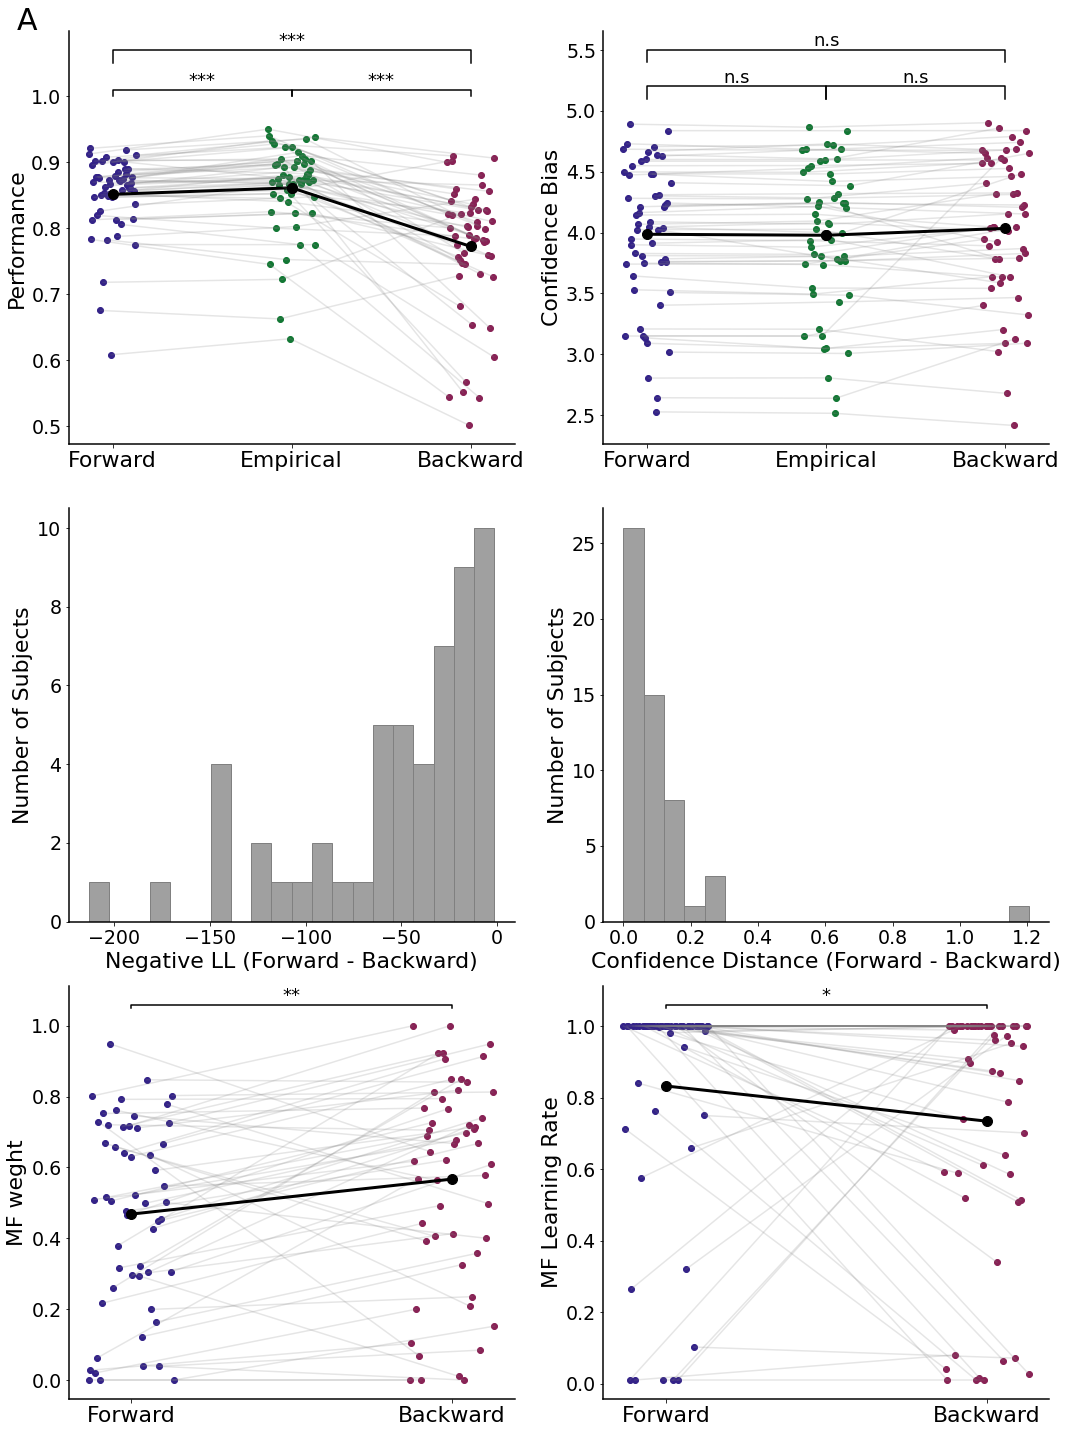

In [38]:

plt.figure(figsize=(15, 20))

plt.subplot(3,2,1)


groups = ["Forward", "Empirical", "Backward"]


comparison_plot(
    avg_df,
    "performance",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [1, 1, 1.05],
    [0.01, 0.01, 0.02],
    y_label="Performance",
)

plt.text(-80, 1.1, "A", fontsize=30)


plt.subplot(3,2,2)


groups = ["Forward", "Empirical", "Backward"]

plt.subplot(3,2,2)

# plt.text(-100, 5.68, "B", fontsize=30)

groups = ["Forward", "Empirical", "Backward"]

comparison_plot(
    avg_df,
    "avg_conf",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [5.1, 5.1, 5.4],
    [0.1, 0.1, 0.1],
    legend="lower right",
    y_label="Confidence Bias",
)


plt.subplot(3,2,3)

# plt.text(-450, 27, "C", fontsize=30)


plot_histogtram(forward_df["neg_ll"] - back_df["neg_ll"],
                "grey",
                "Negative LL (Forward - Backward)"
)

plt.subplot(3,2,4)

# plt.text(-.07, 31, "D", fontsize=30)

plot_histogtram(forward_df["Confidence Distance"] - back_df["Confidence Distance"],
                "grey",
                "Confidence Distance (Forward - Backward)"
               )



plt.subplot(3,2,5)

# plt.text(-50, 1.1, "E", fontsize=30)

comparison_plot(
    params_df,
    "gamma",
    ["Forward", "Backward"],
    "",
    [["Forward", "Backward"]],
    [1.05, 1.05],
    [0.01, 0.01],
    y_label="MF weght",
)


plt.subplot(3,2,6)

comparison_plot(
    params_df,
    "alpha",
    ["Forward", "Backward"],
    "",
    [["Forward", "Backward"]],
    [1.05, 1.05],
    [0.01, 0.01],
    y_label="MF Learning Rate",
)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"



In [52]:
scaled_brier_df = pd.read_csv("../../results/scaled_brier_df_high.csv")

# Calculate QSR, empirical accuracy (emp_acc), and empirical confidence judgment (emp_cj) 
emp_metrics_df = lv_induction_data.groupby("sub").apply(lambda x: pd.Series({
    "QSR": group_qsr(x),
    "emp_acc": x["cor"].mean(),
    "emp_cj": x["cj"].mean()
})).reset_index().rename(columns={"sub": "subject"})


backward_emp_df = back_sim_df.merge(emp_metrics_df, on="subject")\
                                .merge(scaled_brier_df[["subject", "scaled_QSR"]], on="subject")

forward_cor_aligned = backward_emp_df["subject"].map(forward_sim_df.set_index("subject")["performance"])



# # Add new columns for MetaRL calculations and confidence bias
backward_emp_df["forward_perf"] = forward_cor_aligned
backward_emp_df["MetaRL"] = backward_emp_df["performance"] / backward_emp_df["forward_perf"]

# # Rename columns as needed
backward_emp_df = backward_emp_df.rename(columns={"cor": "backward_cor"})

# # Ensure the DataFrame is correctly formatted
# backward_emp_df = backward_emp_df[['subject', 'backward_cor', 'QSR', 'emp_acc', 'emp_cj', 'scaled_QSR', 'forward_cor', 'MetaRL', 'MetaRL_unscaled']]

backward_with_params = pd.merge(backward_emp_df, forward_df, on =["subject"])

(p = 8.45e-09, r = 0.69,ci = [0.52,0.81])
(p = 3.68e-02, r = 0.28,ci = [0.02,0.51])


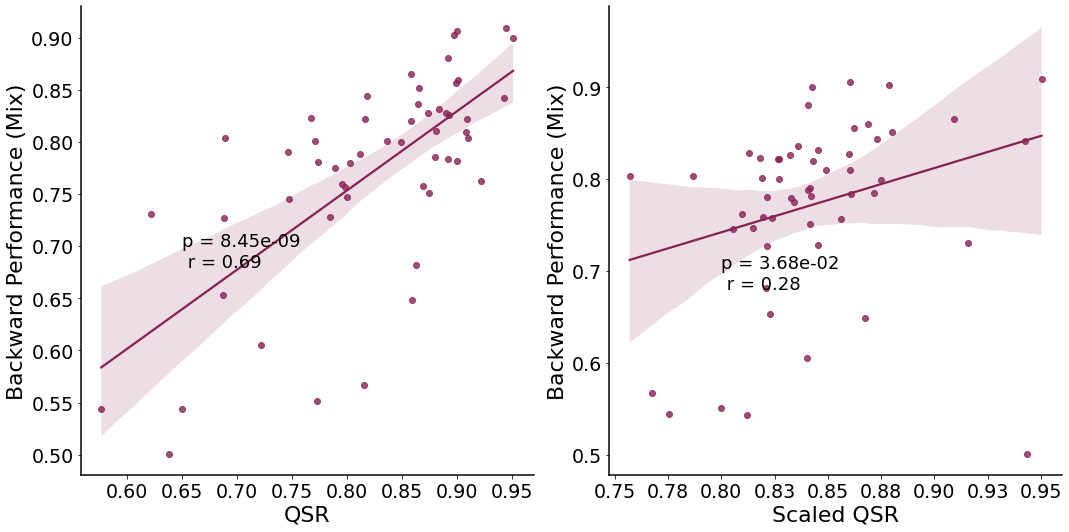

In [129]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(15, 7.5))

plt.subplot(1,2,1)

plot_regression_df(backward_emp_df, "QSR", "performance", color_dict["Backward"] ,0.65, 0.68, "QSR", "Backward Performance (Mix)")

# plt.text(.52, .83, "A", fontsize=30)

plt.subplot(1,2,2)

# plt.text(.74, .845, "B", fontsize=30)


plot_regression_df(backward_emp_df, "scaled_QSR", "performance", color_dict["Backward"] ,0.8, 0.68, "Scaled QSR", "Backward Performance (Mix)")

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

# plt.savefig("../figs/fig4_high.png", dpi=400, bbox_inches = "tight")


(p = 8.86e-01, r = -0.02,ci = [-0.29,0.25])
(p = 1.56e-04, r = 0.49, ci = [0.26,0.67])
(p = 3.78e-01, r = -0.12,ci = [-0.38,0.15])
(p = 1.95e-07, r = 0.64,ci = [0.45,0.77])


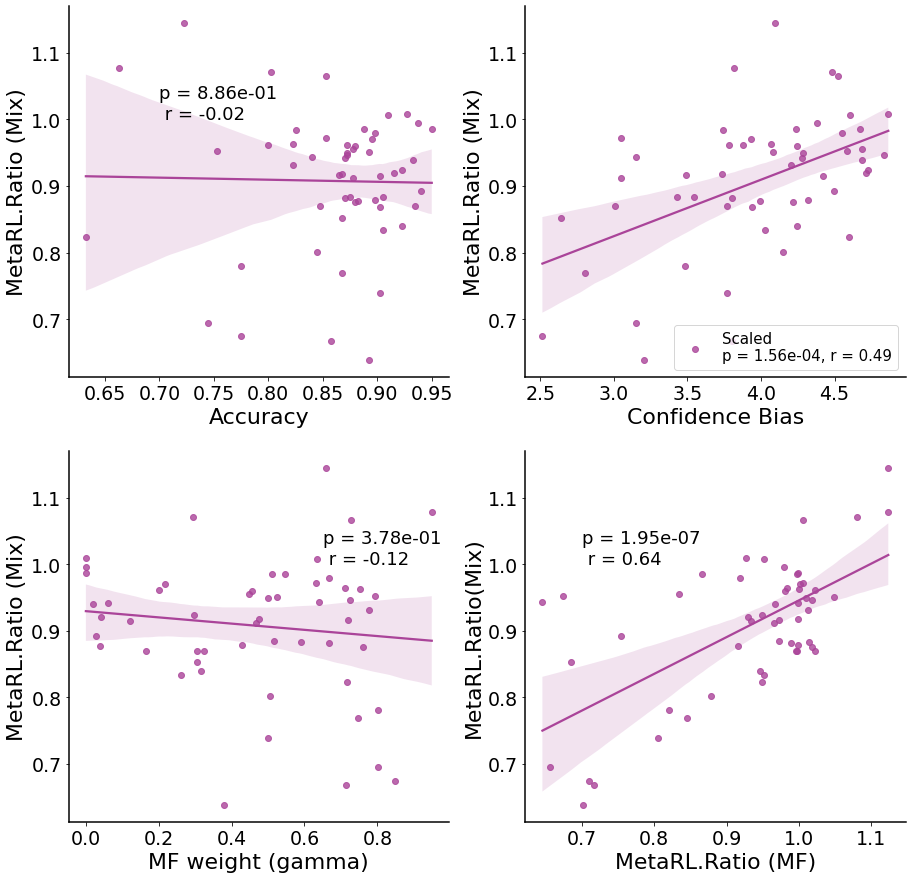

In [131]:

plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)

# plt.text(.55, 1.45, "A", fontsize=30)

plot_regression_df(backward_emp_df, "emp_acc", "MetaRL", "#AA4499",0.7, 1, "Accuracy", "MetaRL.Ratio (Mix)")


plt.subplot(2,2,2)

# plt.text(2.1, 1.45, "B", fontsize=30)

res = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

# res2 = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL_unscaled"])

# stat2, pval2= res2 
# r_low, r_high = res.confidence_interval(.95)



seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL", color="#AA4499", label = "Scaled\np = {:.2e}, r = {:.2f}".format(pval, stat))

# seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL_unscaled", color="#44005D", label = "Unscaled\np = {:.2e}, r = {:.2f}".format(pval2, stat2))


plt.ylabel("MetaRL.Ratio (Mix)", fontsize=22)
plt.xlabel("Confidence Bias", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.legend(fontsize=15, loc = "lower right")


plt.subplot(2,2,3)

# plt.text(.56, 1.45, "C", fontsize=30)

plot_regression_df(backward_with_params, "gamma", "MetaRL", "#AA4499",0.65, 1, "MF weight (gamma)", "MetaRL.Ratio (Mix)")

plt.subplot(2,2,4)

# meta_rl = backward_emp_df[["subject","MetaRL"]].merge(mf_merged_df[["subject", "MetaRL_MF"]], on="subject")

plot_regression_df(meta_rl,"MetaRL_MF", "MetaRL", "#AA4499",0.7, 1, "MetaRL.Ratio (MF)", "MetaRL.Ratio(Mix)")


# # plt.text(-2, 1.45, "D", fontsize=30)

# plot_regression_df(backward_with_params, "", "MetaRL", "#AA4499", 5, 1, "Beta", "MetaRL.Ratio")


# plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

# # plt.savefig("../figs/fig5_high.png", dpi=400, bbox_inches = "tight")



In [64]:
forward_simulation_df = pd.read_csv("../../results/forward_simulation_df.csv")
backward_simulation_df = pd.read_csv("../../results/backward_simulation_df.csv")
backward_unscaled_simulation_df = pd.read_csv("../../results/backward_simulation_unscaled_df.csv")

In [75]:
mf_fwd_avg = forward_simulation_df.groupby("subject").mean().reset_index()[["subject", "cor"]].rename(columns={"cor": "fwd_perf"})
mf_back_avg = backward_simulation_df.groupby("subject").mean().reset_index()[["subject", "cor"]].rename(columns={"cor": "back_perf"})
mf_merged_df = mf_back_avg.merge(mf_fwd_avg, on="subject")
mf_merged_df["MetaRL_MF"] =  mf_merged_df["back_perf"]/ mf_merged_df["fwd_perf"]

In [76]:
plt.figure(figsize=(7,5, 7,5))


,subject,back_perf,fwd_perf,MetaRL_MF
0,45628,0.788875,0.783400,1.006989
1,45640,0.502150,0.799925,0.627746
2,45664,0.500425,0.760300,0.658194
3,45682,0.652875,0.756550,0.862963
4,45745,0.737750,0.759250,0.971683
5,45760,0.759400,0.757950,1.001913
6,45763,0.779975,0.770825,1.011870
7,45805,0.684925,0.733850,0.933331
8,45829,0.776250,0.781850,0.992838
9,45964,0.767750,0.771150,0.995591


(p = 9.93e-05, r = 0.50,ci = [0.27,0.68])


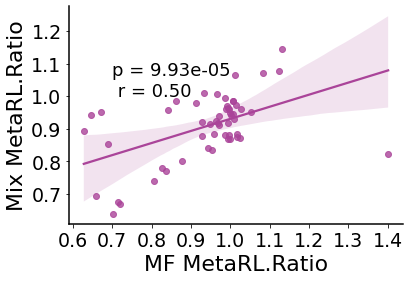

In [99]:
meta_rl = backward_emp_df[["subject","MetaRL"]].merge(mf_merged_df[["subject", "MetaRL_MF"]], on="subject")

plot_regression_df(meta_rl,"MetaRL_MF", "MetaRL", "#AA4499",0.7, 1, "MF MetaRL.Ratio", "Mix MetaRL.Ratio")


In [82]:
mf_merged_df[mf_merged_df["MetaRL_MF"]> 1.2]

,subject,back_perf,fwd_perf,MetaRL_MF
25,46489,0.7386,0.527075,1.401319


In [83]:
pd.read_csv("../../results/forward_df.csv")

,Unnamed: 0,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound
0,0,45628,1.000000,11.609160,4.605658,0.227874,137.997922,0.774465,4.695518
1,1,45640,0.712177,16.827743,4.462571,0.071960,114.860509,0.418840,4.501244
2,2,45664,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277
3,3,45682,1.000000,10.014854,1.488940,0.821554,144.475233,0.728441,4.373464
4,4,45745,1.000000,9.672207,4.092176,0.945758,188.692218,0.437737,4.950758
5,5,45760,0.871313,20.041560,1.000000,0.929745,80.950285,0.551919,4.718982
6,6,45763,1.000000,16.674608,2.498130,0.881425,59.649345,0.963744,4.703341
7,7,45805,1.000000,7.342097,4.681814,0.879261,206.220459,0.245971,4.961583
8,8,45829,1.000000,13.006700,1.294533,0.847562,111.491052,0.743770,4.435145
9,9,45964,0.866118,12.043129,1.579689,0.823172,123.916290,0.823909,4.395193


In [115]:
from Fitting import fit_for_all_subjects_parallel, fit_brier
from Forward import forward_fitting

n_fitting = 120
n_threads = 100
data = preprocess_data("../../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "hc")
subjects = data["sub"].unique()

forward_params_ranges = [[0.01, 1], [0.01, 100], [1, 5], [0.01, 1]]
forward_res = fit_for_all_subjects_parallel(forward_params_ranges, n_threads, n_fitting, subjects, data, forward_fitting, True)
forward_df = make_df_after_fitting(forward_res, ["alpha", "beta", "lbound", "bound_range"], subjects)
forward_df["hbound"] = (5 - forward_df["lbound"]) * forward_df["bound_range"] + forward_df["lbound"]
# forward_df.to_csv("../results/forward_df_high.csv")


In [116]:
from Forward import simulate_with_params 

temp = simulate_with_params(forward_df, data, subjects, n= 200)

In [118]:
fwd_sim_res = temp

In [119]:
from Backward import fit_model_backward

backward_params_ranges = [[0.01, 1], [0.01, 100], [1, 5], [0.01, 1]]
backward_res = fit_for_all_subjects_parallel(backward_params_ranges, n_threads, n_fitting, subjects, data, fit_model_backward, True)
backward_df = make_df_after_fitting(backward_res, ["alpha", "beta", "lbound", "bound_range"], subjects)
backward_df["hbound"] = (5 - backward_df["lbound"]) * backward_df["bound_range"] + backward_df["lbound"]

In [120]:
back_sim_res = simulate_with_params(backward_df, data, subjects, n= 200)

In [124]:
fwd_sim_res = fwd_sim_res.rename(columns={"sub": "subject"})
back_sim_res = back_sim_res.rename(columns={"sub": "subject"})

mf_fwd_avg = fwd_sim_res.groupby("subject").mean().reset_index()[["subject", "cor"]].rename(columns={"cor": "fwd_perf"})
mf_back_avg = back_sim_res.groupby("subject").mean().reset_index()[["subject", "cor"]].rename(columns={"cor": "back_perf"})
mf_merged_df = mf_back_avg.merge(mf_fwd_avg, on="subject")
mf_merged_df["MetaRL_MF"] =  mf_merged_df["back_perf"]/ mf_merged_df["fwd_perf"]

(p = 1.95e-07, r = 0.64,ci = [0.45,0.77])


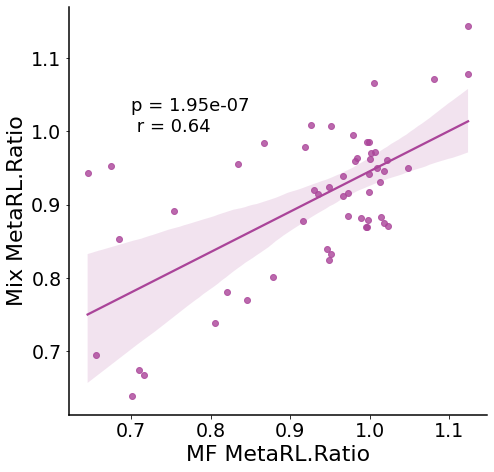

In [126]:

plt.figure(figsize=(7.5, 7.5))

meta_rl = backward_emp_df[["subject","MetaRL"]].merge(mf_merged_df[["subject", "MetaRL_MF"]], on="subject")

plot_regression_df(meta_rl,"MetaRL_MF", "MetaRL", "#AA4499",0.7, 1, "MF MetaRL.Ratio", "Mix MetaRL.Ratio")


In [110]:
backward_df

,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound
0,46489,0.01,0.0,4.561052,0.17729,277.258872,0.851633,4.638873


In [113]:
params_df[params_df["subject"] ==46489]

,subject,Confidence Distance,neg_ll,gamma,alpha,beta,n,p,lbound,bound_range,hbound,model,x_idx,transition_mean
25,46489,0.851677,264.605624,0.717748,0.01,0.01,73,0.794,4.597882,0.01,4.601903,Forward,26,18.939547
79,46489,0.851633,277.261037,1.000000,0.01,0.01,7,0.402,4.597953,0.01,4.601973,Backward,226,10.412935
